## Dogs vs Cats Image Classification with CNN and transfer Learning

### This notebook solves the image classifcation challenge of dogs vs cats with deep learning. I look at applying Convolutional NN and transfer learning (VGG16) to solve a binary image classifcation problem of dogs and cats images.

### The notebook is organized into the following sections:
 1. Build a smaller dataset from original dataset (downloaded from Kaggle)
 2. Data Preparations
 3. Basic CNN model and performance evaluation
 4. Basic CNN model with Regularization (dropout)
 5. Basic CNN model with Image Augmentation
 6. VGG transfer learning (out of box, used as feature extractor)
 7. Fine-tuned VGG transfer CNN model
   -   use augmented image data
   -   freeze first 3 Conv blocks of VGG16, while allowing 4th and 5th Conv blocks to update.

In [1]:
import glob ## unix style path name finder
import numpy as np
import os
import shutil ## high level file operations

np.random.seed(42)

In [2]:
files=glob.glob('train/*')
cat_files=[fn for fn in files if 'cat' in fn ]
dog_files=[fn for fn in files if 'dog' in fn ]

print('cat file number:\t', len(cat_files))
print('dog file number:\t', len(dog_files))

cat file number:	 12500
dog file number:	 12500


### Build a smaller dataset, with 3000 training images, 1000 validation images, and 1000 test images, with equal cat and dog representation

In [3]:
## random sample 1500 images from cat and dog file name lists, this is our training set
cat_train=np.random.choice(cat_files, size=1500, replace=False)
dog_train=np.random.choice(dog_files, size=1500, replace=False)

## update cat and dog file lists to exclude images used in the training set already.
cat_files=list(set(cat_files)-set(cat_train))
dog_files=list(set(dog_files)-set(dog_train))

## do the same thing to create the validation set
cat_val=np.random.choice(cat_files, size=500, replace=False)
dog_val=np.random.choice(dog_files, size=500, replace=False)

cat_files=list(set(cat_files)-set(cat_val))
dog_files=list(set(dog_files)-set(dog_val))

## do the same to create the test set
cat_test=np.random.choice(cat_files, size=500, replace=False)
dog_test=np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets: ', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets: ', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets:  (1500,) (500,) (500,)
Dog datasets:  (1500,) (500,) (500,)


In [4]:
## create seperate folders to store our training, val and test data
train_dir='training_data'
val_dir='val_data'
test_dir='test_data'

train_files=np.concatenate([cat_train, dog_train])
val_files=np.concatenate([cat_val, dog_val])
test_files=np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

In [5]:
for fn in train_files:
    shutil.copy(fn, train_dir)

In [6]:
for fn in val_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

### Data preparations

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

Using TensorFlow backend.


In [8]:
IMG_DIM=(150, 150)

## prepare training images in to numpy arrays: train_imgs, training image labels in list train_labels
train_files=glob.glob('training_data/*')
train_imgs=[img_to_array(load_img(fn, target_size=IMG_DIM)) for fn in train_files]
train_imgs=np.array(train_imgs)
train_labels=[fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

## do the same thing for validation images
val_files=glob.glob('val_data/*')
val_imgs=[img_to_array(load_img(fn, target_size=IMG_DIM)) for fn in val_files]
val_imgs=np.array(val_imgs)
val_labels=[fn.split('\\')[1].split('.')[0].strip() for fn in val_files]

print('train data shape:\t', train_imgs.shape)
print('val data shape:\t', val_imgs.shape)


train data shape:	 (3000, 150, 150, 3)
val data shape:	 (1000, 150, 150, 3)


In [9]:
## now scale all image arrays in the range of 0-1 instead of 0-255
train_imgs_scaled=train_imgs/255.
val_imgs_scaled=val_imgs/255.

(150, 150, 3)


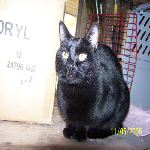

In [10]:
print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [11]:
##encode our class labels as 0 and 1 for cat and dog
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(train_labels)
train_labels_enc=le.transform(train_labels)
val_labels_enc=le.transform(val_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


In [17]:
##configure training parameters:
batch_size=30
num_classes=2
epochs=3
input_shape=(150, 150, 3)

### Basic CNN model

In [20]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model=Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)             0         
__________

In [21]:
history=model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                 validation_data=(val_imgs_scaled, val_labels_enc),
                 batch_size=batch_size, 
                 epochs=epochs,
                 verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/3
3000/3000 [==============================] - 59s 20ms/step - loss: 1.2134 - acc: 0.5263 - val_loss: 0.6809 - val_acc: 0.6090
Epoch 2/3
3000/3000 [==============================] - 59s 20ms/step - loss: 0.6745 - acc: 0.6203 - val_loss: 0.6382 - val_acc: 0.6460
Epoch 3/3
3000/3000 [==============================] - 60s 20ms/step - loss: 0.5871 - acc: 0.6977 - val_loss: 0.6231 - val_acc: 0.6890


### CNN model with Regularization

In [22]:
## add dropout layers to our model, we add to last two dense layers' output

model=Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

history=model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                 validation_data=(val_imgs_scaled, val_labels_enc),
                 batch_size=batch_size, 
                 epochs=epochs,
                 verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 3000 samples, validate on 1000 samples
Epoch 1/3
3000/3000 [==============================] - 61s 20ms/step - loss: 0.8322 - acc: 0.5423 - val_loss: 0.6849 - val_acc: 0.5330
Epoch 2/3
3000/3000 [==============================] - 62s 21ms/step - loss: 0.6888 - acc: 0.6003 - val_loss: 0.6356 - val_acc: 0.6490
Epoch 3/3
3000/3000 [==============================] - 62s 21ms/step - loss: 0.6128 - acc: 0.6780 - val_loss: 0.6617 - val_acc: 0.6630


In [23]:
model.save('cats_dogs_basic_cnn.h5')

### Basic CNN with Image Augmentation

In [24]:
## let's initialize two data generators for the training and validation datasets
train_datagen=ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50, width_shift_range=0.2, 
                                 height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen=ImageDataGenerator(rescale=1./255)

Labels:  ['cat', 'cat', 'cat', 'cat', 'cat']


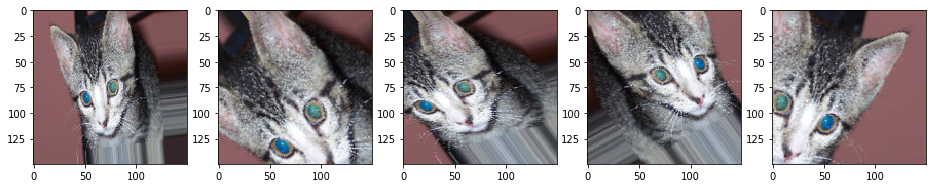

In [40]:
## check an example
img_id=498
cat_generator=train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1], batch_size=1)

cat=[next(cat_generator) for i in range(0,5)]

fig, ax=plt.subplots(1,5, figsize=(16,6))
print('Labels: ',[item[1][0] for item in cat])
l=[ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [41]:
# now let's train a CNN model with regularization and image augmentation
train_generator=train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator=val_datagen.flow(val_imgs, val_labels_enc, batch_size=20)
input_shape=(150, 150, 3)

model=Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

history=model.fit_generator(train_generator, steps_per_epoch=100, epochs=3, validation_data=val_generator, validation_steps=50,
                           verbose=1)

Epoch 1/3
100/100 [==============================] - 63s 628ms/step - loss: 0.8087 - acc: 0.5400 - val_loss: 0.6859 - val_acc: 0.5370
Epoch 2/3
100/100 [==============================] - 63s 633ms/step - loss: 0.6913 - acc: 0.5723 - val_loss: 0.6771 - val_acc: 0.6040
Epoch 3/3
100/100 [==============================] - 64s 642ms/step - loss: 0.6673 - acc: 0.6083 - val_loss: 0.6718 - val_acc: 0.6260


In [42]:
model.save('cats_dogs_cnn_img_aug.h5')

### Leverage Transfer Learning

In [48]:
## use VGG16 as feature extractor

from keras.applications import vgg16
from keras.models import Model
import keras

vgg=vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

output=vgg.layers[-1].output
output=keras.layers.Flatten()(output)

vgg_model=Model(vgg.input, output)

vgg_model.trainable=False

for layer in vgg_model.layers:
    layer.trainable=False

import pandas as pd
pd.set_option('max_colwidth', -1)
layers=[(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001FED850F780>,input_5,False
1,<keras.layers.convolutional.Conv2D object at 0x000001FED850F860>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000001FED850F828>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000001FED8528B38>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000001FED8528978>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000001FED84F6B70>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000001FE48A8D240>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000001FE48AAADD8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000001FE47804E48>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000001FE4782E5F8>,block3_conv3,False


In [49]:
def get_bottleneck_features(model, input_imgs):
    features=model.predict(input_imgs, verbose=0)
    return features

train_features_vgg=get_bottleneck_features(vgg_model, train_imgs_scaled)
val_features_vgg=get_bottleneck_features(vgg_model, val_imgs_scaled)

print('train bottleneck features:', train_features_vgg.shape)
print('val_bottleneck features:', val_features_vgg.shape)
    

train bottleneck features: (3000, 8192)
val_bottleneck features: (1000, 8192)


In [51]:
input_shape=vgg_model.output_shape[1]


In [63]:
## build model
from keras.layers import InputLayer

model=Sequential()
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(val_features_vgg, val_labels_enc),
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2535 - acc: 0.9007 - val_loss: 0.3003 - val_acc: 0.8760
Epoch 2/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1980 - acc: 0.9217 - val_loss: 0.3639 - val_acc: 0.8630
Epoch 3/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1775 - acc: 0.9300 - val_loss: 0.2725 - val_acc: 0.8970
Epoch 4/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1736 - acc: 0.9413 - val_loss: 0.3293 - val_acc: 0.8880
Epoch 5/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1383 - acc: 0.9483 - val_loss: 0.3368 - val_acc: 0.8880
Epoch 6/30
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1203 - acc: 0.9567 - val_loss: 0.3320 - val_acc: 0.8940
Epoch 7/30
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1038 - acc: 0.9593 - val_loss: 0.5836 - val_acc: 0.8610
Epoch 8/30
300

#### Looks like our Transfer Learning model is working nice even out of the box! Validation Accuracy reached as high as 90%

In [66]:
model.save('cats_dogs_tl_basic_cnn.h5')

### now try transfer learning with Augmented image data

In [ ]:
model=Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

history=model.fit_generator(train_generator, steps_per_epoch=100, epochs=20, 
                           validation_data=val_generator, validation_steps=50, verbose=1)

In [68]:
model.save('cats_dogs_tl_img_aug_cnn.h5')

### Pretrained model with Fine tuning

In [70]:
## try unfreeze convolution block 4 and 5, keeping first 3 blocks frozen

vgg_model.trainable=True

set_trainable=False

for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001FED850F780>,input_5,False
1,<keras.layers.convolutional.Conv2D object at 0x000001FED850F860>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000001FED850F828>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000001FED8528B38>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000001FED8528978>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000001FED84F6B70>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000001FE48A8D240>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000001FE48AAADD8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000001FE47804E48>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000001FE4782E5F8>,block3_conv3,False


In [75]:
model=Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_46 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
________________________________________________________

In [77]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=3,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

Epoch 1/3
100/100 [==============================] - 523s 5s/step - loss: 7.9096 - acc: 0.5090 - val_loss: 8.1719 - val_acc: 0.4930
Epoch 2/3
100/100 [==============================] - 538s 5s/step - loss: 8.0420 - acc: 0.5007 - val_loss: 7.9946 - val_acc: 0.5040
Epoch 3/3
100/100 [==============================] - 531s 5s/step - loss: 8.1074 - acc: 0.4967 - val_loss: 7.9946 - val_acc: 0.5040
